Plot fit error distributions from different model fits to Baker et al data

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import record_0_main as rcd_0
import record_1_ma_ext as rcd_1
import record_2_lin_ln as rcd_2

from disp import set_plot, plot_b

FPS = 30.03
DT = 1/FPS

NNRN = 224

In [31]:
MDLS_META = {
    'ma': ('k', 'baker_ma.npy', rcd_0.smlt_ma),
    'lnma': ('m', 'baker_ma.npy', rcd_0.smlt_lnma),
    # 'linma': ('b', 'baker_ma.npy', rcd_0.smlt_linma),
    
    # 'lin': ('b', 'baker_lin.npy', rcd_2.smlt_lin),
    # 'linr': ('b', 'baker_linr.npy', rcd_2.smlt_linr),
    
    # 'ln': ('m', 'baker_ln.npy', rcd_2.smlt_ln),
    # 'lnr': ('m', 'baker_lnr.npy', rcd_2.smlt_lnr),
    # 'lnr_relu': ('m', 'baker_lnr_relu.npy', rcd_2.smlt_lnr_relu),
    # 'lnr_relu_flex': ('m', 'baker_lnr_relu_flex.npy', rcd_2.smlt_lnr_relu_flex),
    
    # 'ma_ind_ta': ('c', 'baker_ma_ind_ta.npy', rcd_1.smlt_ma_ind_ta),
}

In [32]:
df_s = pd.read_csv('data/simple/neur/baker_resampled_s.csv')
df_p = pd.read_csv('data/simple/neur/baker_resampled_p.csv')

In [33]:
T = np.array(df_s['T'])
I_S = np.array(df_s['S'])
I_P = np.array(df_p['P'])

R_SS = np.array(df_s[[f'R_{cnrn}' for cnrn in range(NNRN)]])
R_PS = np.array(df_p[[f'R_{cnrn}' for cnrn in range(NNRN)]])

In [34]:
r_mdl_ss_all = {}
r_mdl_ps_all = {}

for mdl, (color, fname, smlt) in MDLS_META.items():
    path = os.path.join('data/simple/neur/', fname)
    params = np.load(path, allow_pickle=True)[0]
    
    r_mdl_ss = smlt(I_S, 0*I_P, params, DT)
    r_mdl_ss_all[mdl] = r_mdl_ss
    
    r_mdl_ps = smlt(0*I_S, I_P, params, DT)
    r_mdl_ps_all[mdl] = r_mdl_ps

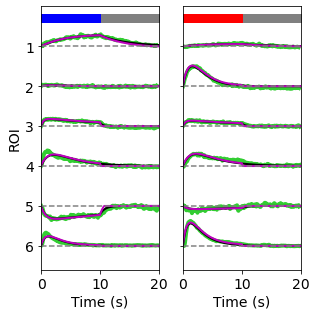

In [46]:
nrns_plot = [11, 79, 21, 148, 5, 118]
nplot = len(nrns_plot)

fig, axs = plt.subplots(1, 2, figsize=(4.5, nplot*.75), tight_layout=True, sharey=True)

y_ticks = []

for cnrn, inrn in enumerate(nrns_plot):
    y_tick = -5*cnrn
    
    axs[0].plot(T, R_SS[:, inrn]/2+y_tick, c='limegreen', lw=4)
    for mdl, (color, fname, smlt) in MDLS_META.items():
        axs[0].plot(T, r_mdl_ss_all[mdl][:, inrn]/2 +y_tick, color=color, lw=2)

    axs[0].axhline(y_tick, c='gray', ls='--')
        
    axs[1].plot(T, R_PS[:, inrn]/2+y_tick, c='limegreen', lw=4)
    for mdl, (color, fname, smlt) in MDLS_META.items():
        axs[1].plot(T, r_mdl_ps_all[mdl][:, inrn]/2 +y_tick, color=color, lw=2)

    axs[1].axhline(y_tick, c='gray', ls='--')
    
    y_ticks.append(y_tick)
    
b_s = np.zeros(len(T))
b_s[I_S == 1] = 1

plot_b(axs[0], T, b_s, extent=[T[0], T[-1]+DT, 3, 4], c=['gray', 'b', 'r'])

b_p = np.zeros(len(T))
b_p[I_P == 1] = 2

plot_b(axs[1], T, b_p, extent=[T[0], T[-1]+DT, 3, 4], c=['gray', 'b', 'r'])

axs[0].set_ylabel('ROI')
    
for ax in axs:
    set_plot(ax, x_lim=(0, 20), y_lim=(-5*nplot+2, 5), y_ticks=y_ticks, y_tick_labels=np.arange(nplot)+1, x_label='Time (s)', font_size=14)
    
fig.savefig('cosyne_2023/1a.svg')

In [7]:
sq_errs = {}

for mdl in MDLS_META:
    r_mdl_ss = r_mdl_ss_all[mdl]
    r_mdl_ps = r_mdl_ps_all[mdl]
    
    sq_err_s = np.nanmean((r_mdl_ss - R_SS)**2, axis=0)
    sq_err_p = np.nanmean((r_mdl_ps - R_PS)**2, axis=0)
    
    sq_errs[mdl] = (sq_err_s+sq_err_p)/2

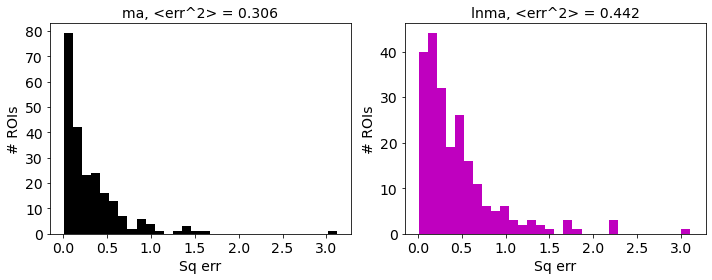

In [8]:
fig, axs = plt.subplots(1, len(MDLS_META), figsize=(10, 4), sharex=True, tight_layout=True)
for ax, mdl in zip(axs, MDLS_META):
    ax.hist(sq_errs[mdl], bins=30, color=MDLS_META[mdl][0])
    mn_sq_err = np.mean(sq_errs[mdl])
    set_plot(ax, x_label='Sq err', y_label='# ROIs', title=f'{mdl}, <err^2> = {mn_sq_err:.3f}', font_size=14)